# Network Anomaly Detection

## Problem Statement

The exponential growth of network traffic has led to an increase in network anomalies, such as cyber attacks, network failures, and hardware malfunctions. Network anomaly detection is a critical task for maintaining the security and stability of computer networks. The objective of this assignment is to help students understand how K-Means and Normalized Cut algorithms can be used for network anomaly detection.

**Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, kmeans_plusplus
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = [10, 6]

%load_ext autotime

time: 0 ns (started: 2023-09-11 23:36:44 +03:00)


**Utility Functions**

In [2]:
def nth_max(X, n):
    return np.partition(X.flatten(), -n)[-n]

time: 0 ns (started: 2023-09-11 23:36:44 +03:00)


In [3]:
def np_value_counts(ndarray):
    unique, counts = np.unique(ndarray, return_counts=True)
    return np.asarray((unique, counts)).T

time: 0 ns (started: 2023-09-11 23:36:44 +03:00)


## 1. Download Datset and Understand the Format

For this assignment, we will use the ”KDD Cup 1999” dataset, which is a widely used benchmark dataset for network anomaly detection. This dataset contains network traffic data collected from a simulated environment, including features such as protocol type, service, source and destination IP addresses, source and destination ports, and attack types. The data is available at the following [link](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). You will use the `kddcup.data.gz` for training and `corrected.gz` for testing. Analyze the dataset and preprocess the dataset to be ready for clustering. ”Change the categorical features to numerical”

In [4]:
with open('data/kddcup.names') as file:
    lines = [line.rstrip() for line in file]
columns = [line.split(":")[0] for line in lines[1:]]
columns.append('label')

time: 0 ns (started: 2023-09-11 23:36:44 +03:00)


In [5]:
presaved_files = os.path.isfile('train.gz') and os.path.isfile('train10.gz') and os.path.isfile('test.gz')
presaved_files

False

time: 16 ms (started: 2023-09-11 23:36:44 +03:00)


In [6]:
if presaved_files:
    train = pd.read_csv('train.gz', compression='gzip')
    train10 = pd.read_csv('train10.gz', compression='gzip')
    test = pd.read_csv('test.gz', compression='gzip')

time: 0 ns (started: 2023-09-11 23:36:44 +03:00)


In [7]:
if not presaved_files:
    train = pd.read_csv('data/kddcup.data.gz', compression='gzip', names=columns)
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


time: 17.4 s (started: 2023-09-11 23:36:44 +03:00)


In [8]:
if not presaved_files:
    train10 = pd.read_csv('data/kddcup.data_10_percent.gz', compression='gzip', names=columns)
train10

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


time: 1.73 s (started: 2023-09-11 23:37:02 +03:00)


In [9]:
if not presaved_files:
    test = pd.read_csv('data/corrected.gz', compression='gzip', names=columns)
test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311024,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311025,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311026,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.
311027,0,udp,private,SF,105,147,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.


time: 1.2 s (started: 2023-09-11 23:37:03 +03:00)


**One-Hot Encoding Categorical Columns**

In [10]:
def one_hot_encode_df(df1, df2, df3, columns_to_encode):
    dataframes = [df1, df2, df3]

    # Concatenate the DataFrames vertically
    concatenated_df = pd.concat(dataframes)

    # Perform one-hot encoding on the concatenated DataFrame
    encoded_df = pd.get_dummies(concatenated_df, columns=columns_to_encode)

    # Split the encoded DataFrame back into the original three DataFrames
    df1_encoded = encoded_df[:len(df1)]
    df2_encoded = encoded_df[len(df1):len(df1)+len(df2)]
    df3_encoded = encoded_df[len(df1)+len(df2):]

    return df1_encoded, df2_encoded, df3_encoded

time: 0 ns (started: 2023-09-11 23:37:05 +03:00)


In [11]:
if not presaved_files:
    train, train10, test = one_hot_encode_df(train, train10, test, ['protocol_type', 'service', 'flag'])

time: 8.56 s (started: 2023-09-11 23:37:05 +03:00)


**Label encode labels**

In [12]:
if not presaved_files:
    le = preprocessing.LabelEncoder()
    le.fit(pd.concat([train['label'], test['label']], axis=0))
    le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    train.replace({'label': le_mapping}, inplace=True)
    train10.replace({'label': le_mapping}, inplace=True)
    test.replace({'label': le_mapping}, inplace=True)

time: 50.6 s (started: 2023-09-11 23:37:13 +03:00)


**Save Processed Data for Later Runs**

In [13]:
train.iloc[:-1]

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,215,45076,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,162,4528,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,236,1228,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,233,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898425,0,219,244,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898426,0,212,2288,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898427,0,219,236,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4898428,0,218,3610,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


time: 1 s (started: 2023-09-11 23:38:04 +03:00)


In [14]:
if not presaved_files:
    train.to_csv("train.gz", index=False, compression="gzip")
    train10.to_csv("train10.gz", index=False, compression="gzip")
    test.to_csv("test.gz", index=False, compression="gzip")
    
    presaved_files = True

time: 3min 23s (started: 2023-09-11 23:38:05 +03:00)


**Dropping the label column**

In [15]:
train_label = train.loc[:, 'label']
train.drop(['label'], axis=1, inplace=True)

time: 1.31 s (started: 2023-09-11 23:41:29 +03:00)


In [16]:
train10_label = train10.loc[:, 'label']
train10.drop(['label'], axis=1, inplace=True)

time: 156 ms (started: 2023-09-11 23:41:30 +03:00)


In [17]:
test_label = test.loc[:, 'label']
test.drop(['label'], axis=1, inplace=True)

time: 281 ms (started: 2023-09-11 23:41:30 +03:00)


**Dataset Analysis**

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4898431 entries, 0 to 4898430
Columns: 123 entries, duration to flag_SH
dtypes: bool(85), float64(15), int64(23)
memory usage: 1.8 GB
time: 31 ms (started: 2023-09-11 23:41:31 +03:00)


In [19]:
train10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494021 entries, 0 to 494020
Columns: 123 entries, duration to flag_SH
dtypes: bool(85), float64(15), int64(23)
memory usage: 187.0 MB
time: 15 ms (started: 2023-09-11 23:41:31 +03:00)


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311029 entries, 0 to 311028
Columns: 123 entries, duration to flag_SH
dtypes: bool(85), float64(15), int64(23)
memory usage: 117.8 MB
time: 16 ms (started: 2023-09-11 23:41:31 +03:00)


In [21]:
train.nunique()

duration           9883
src_bytes          7195
dst_bytes         21493
land                  2
wrong_fragment        3
                  ...  
flag_S1               2
flag_S2               2
flag_S3               2
flag_SF               2
flag_SH               2
Length: 123, dtype: int64

time: 5.47 s (started: 2023-09-11 23:41:31 +03:00)


In [22]:
train10.nunique()

duration           2495
src_bytes          3300
dst_bytes         10725
land                  2
wrong_fragment        3
                  ...  
flag_S1               2
flag_S2               2
flag_S3               2
flag_SF               2
flag_SH               2
Length: 123, dtype: int64

time: 609 ms (started: 2023-09-11 23:41:36 +03:00)


In [23]:
test.nunique()

duration           745
src_bytes         2504
dst_bytes         9202
land                 2
wrong_fragment       3
                  ... 
flag_S1              2
flag_S2              2
flag_S3              2
flag_SF              2
flag_SH              2
Length: 123, dtype: int64

time: 328 ms (started: 2023-09-11 23:41:37 +03:00)


**Removing `num_outbound_cmds` column from dataset as it has only one value**

In [24]:
train.drop(columns=['num_outbound_cmds'], inplace=True)

time: 2.25 s (started: 2023-09-11 23:41:37 +03:00)


In [25]:
train10.drop(columns=['num_outbound_cmds'], inplace=True)

time: 250 ms (started: 2023-09-11 23:41:39 +03:00)


In [26]:
test.drop(columns=['num_outbound_cmds'], inplace=True)

time: 188 ms (started: 2023-09-11 23:41:40 +03:00)


**Converting to NumPy arrays**

In [27]:
x_train = train.to_numpy().astype('float32')
y_train = train_label.to_numpy().astype('uint8')

x_train10 = train10.to_numpy().astype('float32')
y_train10 = train10_label.to_numpy().astype('uint8')

x_test = test.to_numpy().astype('float32')
y_test = test_label.to_numpy().astype('uint8')

time: 1min 18s (started: 2023-09-11 23:41:40 +03:00)


**Running PCA on dataset to reduce dimensionality**

In [28]:
pca = PCA()
pca.fit(x_train)

# Calculate the number of components based on the desired variance ratio
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
n_components = len(explained_variance_ratio_cumsum[explained_variance_ratio_cumsum < 0.9999]) + 1
n_components

2

time: 1min 2s (started: 2023-09-11 23:42:59 +03:00)


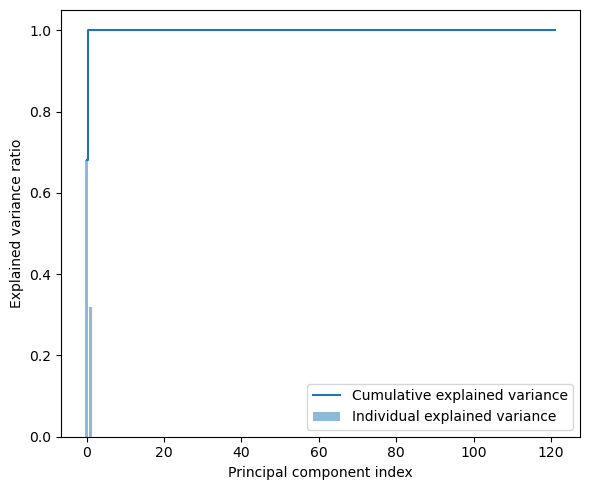

time: 828 ms (started: 2023-09-11 23:44:02 +03:00)


In [29]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.figure(figsize=(6,5))
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
x_train = pca.transform(x_train)[:, :n_components]

time: 14.4 s (started: 2023-09-11 23:44:02 +03:00)


In [31]:
x_train10 = pca.transform(x_train10)[:, :n_components]

time: 672 ms (started: 2023-09-11 23:44:17 +03:00)


In [32]:
x_test = pca.transform(x_test)[:, :n_components]

time: 531 ms (started: 2023-09-11 23:44:18 +03:00)


**Finalized Dataset**

In [33]:
x_train

array([[-1.6059680e+03,  4.3982875e+04],
       [-1.6715563e+03,  3.4348955e+03],
       [-1.5985807e+03,  1.3487267e+02],
       ...,
       [-1.6158412e+03,  2.5168782e+03],
       [-1.6155789e+03,  1.4087787e+02],
       [-1.6156211e+03,  4.8779068e+00]], dtype=float32)

time: 31 ms (started: 2023-09-11 23:44:18 +03:00)


In [34]:
y_train

array([16, 16, 16, ..., 16, 16, 16], dtype=uint8)

time: 16 ms (started: 2023-09-11 23:44:18 +03:00)


In [35]:
x_train10

array([[-1652.27   ,  4356.8896 ],
       [-1595.811  ,  -607.12823],
       [-1599.5469 ,   243.87297],
       ...,
       [-1631.5894 ,   106.88285],
       [-1543.5894 ,   106.85554],
       [-1615.5789 ,   140.87787]], dtype=float32)

time: 16 ms (started: 2023-09-11 23:44:18 +03:00)


In [36]:
y_train10

array([16, 16, 16, ..., 16, 16, 16], dtype=uint8)

time: 16 ms (started: 2023-09-11 23:44:18 +03:00)


In [37]:
x_test

array([[-1729.9166,  -947.0867],
       [-1729.9166,  -947.0867],
       [-1729.9166,  -947.0867],
       ...,
       [-1729.9163,  -946.0867],
       [-1729.9163,  -946.0867],
       [-1729.9163,  -946.0867]], dtype=float32)

time: 16 ms (started: 2023-09-11 23:44:18 +03:00)


In [38]:
y_test

array([16, 16, 16, ..., 16, 16, 16], dtype=uint8)

time: 16 ms (started: 2023-09-11 23:44:18 +03:00)


## 2. Clustering Using K-Means (Your implementation)

We will use K-Means to cluster the network traffic data and identify anomalies. Every data traffic is a feature vector of 41 dimension. We will use this feature representation to do the clustering.

• We will change the K of the K-means algorithm between {7, 15, 23, 31, 45} clusters. You will produce different clusters.

In [39]:
def k_means_clustering(X, k, epsilon=1e-6, num_iters=100):
    # Initialize k centroids using k-means++
    centroids, _ = kmeans_plusplus(X, n_clusters=k)
    
    old_centroids = np.copy(centroids)
    for t in range(num_iters):
        clusters = [set() for i in range(k)]
        
        # Cluster Assignment Step
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
    
        # Centroid Update Step
        for i in range(k):
            clusters[i] = np.where(labels==i)[0]
            if len(clusters[i]) == 0:
                centroids[i] = None
            else:
                centroids[i] = np.mean(X[clusters[i]], axis=0)

        if np.linalg.norm(centroids - old_centroids) <= epsilon:
            labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
            return labels, centroids
        else:
            old_centroids = np.copy(centroids)
    
    labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
    return labels, centroids

time: 15 ms (started: 2023-09-11 23:44:18 +03:00)


In [40]:
def k_means_test(x_test, centroids):
    return np.argmin(np.linalg.norm(x_test[:, np.newaxis] - centroids, axis=2), axis=1)

time: 0 ns (started: 2023-09-11 23:44:18 +03:00)


In [41]:
results = dict()
for k in [7, 15, 23, 31, 45]:
    print(f"@ k = {k}")
    labels, centroids = k_means_clustering(x_train10, k)
    
    results[k] = dict()
    results[k]['labels'] = labels
    results[k]['centroids'] = centroids
    results[k]['y_pred'] = k_means_test(x_test, centroids)

@ k = 7
@ k = 15
@ k = 23
@ k = 31
@ k = 45
time: 1min 34s (started: 2023-09-11 23:44:18 +03:00)


In [42]:
results

{7: {'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
  'centroids': array([[-9.3010449e+02, -5.3871619e+02],
         [ 6.9337370e+08, -2.1633139e+05],
         [ 5.1323920e+06, -2.6867097e+03],
         [-1.7073772e+02,  5.0085970e+06],
         [ 2.2017508e+06, -1.7770908e+03],
         [-7.6293127e+02,  1.6952436e+06],
         [-1.1510475e+03,  4.3499556e+05]], dtype=float32),
  'y_pred': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)},
 15: {'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
  'centroids': array([[-1.1930992e+03, -9.0026593e+02],
         [ 6.9337370e+08, -2.1633139e+05],
         [ 5.1323920e+06, -2.6867097e+03],
         [-2.3601170e+02,  5.1492880e+06],
         [ 2.2017508e+06, -1.7770908e+03],
         [-1.0024232e+03,  7.2742581e+05],
         [-6.8741638e+02,  1.7126861e+06],
         [ 5.3966234e+04,  6.7127153e+03],
         [-1.1566938e+03,  2.9448275e+05],
         [ 3.5145416e+02,  3.8830678e+06],
         [-1.5509403e+03,  1.3009555e+04],
    

time: 16 ms (started: 2023-09-11 23:45:53 +03:00)


## 3. Normalized Cut (Your implementation)

Here, we will use Normalized cut algorithm to cluster the network traffic data and identify anomalies. For this experiments we need to decrease the size of the dataset for it to run successfully.

• Set the random seed across all experiments to 42.

• Split the training dataset used using train test split in sklearn, and take
only 0.5% of the data in the new training set. Be sure you set stratify = True.

• Apply Normalized Cut algorithm to the preprocessed data to cluster the data into 23 clusters.

• Rerun the experiments on K-Means when K = 23.

• Compare the results of K-Means and Normalized Cut clustering in terms of the number of detected anomalies and their characteristics.

In [43]:
def normalised_cut(X, k_clusters, sim_measure='rbf'):
    # Find Similarity Matrix A using specified similarity measure
    if sim_measure == 'rbf':
        g_optimal = 1 / np.mean(pdist(X))
        A = rbf_kernel(X, gamma=g_optimal)
    elif sim_measure == 'knn':
        k_optimal = int(np.round(np.sqrt(X.shape[0])))
        knn = NearestNeighbors(n_neighbors=151).fit(X)
        A = knn.kneighbors_graph(X).toarray()
    
    # Find Degree Matrix Δ
    delta = np.diag(A.sum(axis=1))
    
    # Calculate the Laplacian Matrix L
    L = delta - A
    
    # Calculate the normalized asymmetric Matrix B
    B = np.dot(np.linalg.inv(delta), L)
    
    # Extract eigenvalues and eigenvectors of B
    lambdas, U = np.linalg.eig(B)
    indices = lambdas.argsort()
    lambdas = np.real(lambdas[indices])
    U = np.real(U[:, indices])
    
    # Run K-Means on smallest k eigenvectors
    kmeans = KMeans(n_clusters=k_clusters, n_init=100)
    kmeans.fit(U[:, 1:k_clusters+1])
    
    return kmeans.labels_

time: 16 ms (started: 2023-09-11 23:45:53 +03:00)


In [44]:
x_train2, _, y_train2, _ = train_test_split(x_train, y_train, train_size=0.0025, random_state=42, stratify=y_train)

time: 2.14 s (started: 2023-09-11 23:45:53 +03:00)


In [45]:
x_train2.shape

(12246, 2)

time: 0 ns (started: 2023-09-11 23:45:55 +03:00)


In [46]:
y_train2.shape

(12246,)

time: 0 ns (started: 2023-09-11 23:45:55 +03:00)


In [47]:
nc_labels = normalised_cut(x_train2, 23)
nc_labels

array([0, 0, 0, ..., 0, 0, 0])

time: 20min 1s (started: 2023-09-11 23:45:55 +03:00)


In [48]:
nc_labels_knn = normalised_cut(x_train2, 23, sim_measure='knn')
nc_labels_knn

array([ 1,  1,  9, ..., 18,  7,  1])

time: 8min 16s (started: 2023-09-12 00:05:57 +03:00)


**K-Means Clustering vs. Normalized Cut**

In [49]:
np_value_counts(results[23]['labels'])

array([[     0, 293220],
       [     1,      1],
       [     2,     59],
       [     3,     16],
       [     4,     24],
       [     5,      9],
       [     6,     55],
       [     7,   1616],
       [     8,   2314],
       [     9,     16],
       [    10,      1],
       [    11,      8],
       [    12,      2],
       [    13,      7],
       [    14,   5499],
       [    15,      7],
       [    16,    220],
       [    17,     16],
       [    18,     21],
       [    19,      3],
       [    20,      4],
       [    21,  15391],
       [    22, 175512]], dtype=int64)

time: 47 ms (started: 2023-09-12 00:14:13 +03:00)


In [50]:
np_value_counts(nc_labels)

array([[    0, 12158],
       [    1,     2],
       [    2,     6],
       [    3,     2],
       [    4,     5],
       [    5,     4],
       [    6,     3],
       [    7,     2],
       [    8,     4],
       [    9,     2],
       [   10,     2],
       [   11,     3],
       [   12,     1],
       [   13,     3],
       [   14,     3],
       [   15,     4],
       [   16,     4],
       [   17,     4],
       [   18,     5],
       [   19,     3],
       [   20,     1],
       [   21,    22],
       [   22,     3]], dtype=int64)

time: 16 ms (started: 2023-09-12 00:14:13 +03:00)


In [51]:
np_value_counts(nc_labels_knn)

array([[   0,  824],
       [   1, 6345],
       [   2,  100],
       [   3,   43],
       [   4,   29],
       [   5, 1080],
       [   6,   42],
       [   7,  681],
       [   8,   94],
       [   9,  471],
       [  10,  872],
       [  11,   42],
       [  12,   78],
       [  13,  248],
       [  14,  354],
       [  15,  139],
       [  16,   48],
       [  17,   35],
       [  18,  462],
       [  19,   40],
       [  20,   93],
       [  21,   48],
       [  22,   78]], dtype=int64)

time: 0 ns (started: 2023-09-12 00:14:13 +03:00)


## 4. Evaluation

We will evaluate models based on their ability to detect network anomalies accurately. You will be required to use the following metrics to evaluate the quality of their models:

• Precision

• Recall

• F1 score

• Conditional Entropy

**Running K-Means on `x_train2` for evaluation purposes**

In [52]:
km_results = dict()
for k in [7, 15, 23, 31, 45]:
    print(f"@ k = {k}")
    labels, centroids = k_means_clustering(x_train2, k)
    
    km_results[k] = dict()
    km_results[k]['labels'] = labels
    km_results[k]['centroids'] = centroids
    km_results[k]['y_pred'] = k_means_test(x_test, centroids)

@ k = 7
@ k = 15
@ k = 23
@ k = 31
@ k = 45
time: 2.91 s (started: 2023-09-12 00:14:13 +03:00)


### Precision

In [53]:
def precision_per_cluster(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    return np.max(cont_mat, axis=1) / np.sum(cont_mat, axis=1)

time: 0 ns (started: 2023-09-12 00:14:16 +03:00)


In [54]:
def overall_precision(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    p_per_c = precision_per_cluster(y_true, y_pred)
    return np.sum(np.multiply(np.sum(cont_mat, axis=1) / np.sum(cont_mat), p_per_c))

time: 0 ns (started: 2023-09-12 00:14:16 +03:00)


**K-Means Clustering**

In [55]:
for k in [7, 15, 23, 31, 45]:
    print(f"@ k = {k}:\t{overall_precision(y_train2, km_results[k]['labels'])}")

@ k = 7:	0.581740976645435
@ k = 15:	0.6482116609505144
@ k = 23:	0.8864118895966028
@ k = 31:	0.8948227992813981
@ k = 45:	0.921607055365017
time: 31 ms (started: 2023-09-12 00:14:16 +03:00)


**Normalised Cut**

In [56]:
overall_precision(y_train2, nc_labels)

0.5804344275681856

time: 0 ns (started: 2023-09-12 00:14:16 +03:00)


In [57]:
overall_precision(y_train2, nc_labels_knn)

0.9273232075779844

time: 16 ms (started: 2023-09-12 00:14:16 +03:00)


### Recall

In [58]:
def recall_per_cluster(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    partition_fraction = np.sum(cont_mat[:, np.argmax(cont_mat, axis=1)], axis=0)
    return np.max(cont_mat, axis=1) / partition_fraction

time: 0 ns (started: 2023-09-12 00:14:16 +03:00)


In [59]:
def overall_recall(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    r_per_c = recall_per_cluster(y_true, y_pred)
#     partition_fraction = np.sum(cont_mat[:, np.argmax(cont_mat, axis=1)], axis=0)
#     return np.sum(np.multiply(partition_fraction / np.sum(cont_mat), r_per_c))
    return np.sum(np.multiply(np.sum(cont_mat, axis=1) / np.sum(cont_mat), r_per_c))

time: 0 ns (started: 2023-09-12 00:14:16 +03:00)


**K-Means Clustering**

In [60]:
for k in [7, 15, 23, 31, 45]:
    print(f"@ k = {k}:\t{overall_recall(y_train2, km_results[k]['labels'])}")

@ k = 7:	0.9918638734703205
@ k = 15:	0.9384943723120475
@ k = 23:	0.9182770094459775
@ k = 31:	0.7191305229368276
@ k = 45:	0.700478344682803
time: 31 ms (started: 2023-09-12 00:14:16 +03:00)


**Normalised Cut**

In [61]:
overall_recall(y_train2, nc_labels)

0.9928383569930461

time: 16 ms (started: 2023-09-12 00:14:16 +03:00)


In [62]:
overall_recall(y_train2, nc_labels_knn)

0.5149591559179939

time: 16 ms (started: 2023-09-12 00:14:16 +03:00)


### F1 Score

In [63]:
def overall_f1_score(y_true, y_pred):
    p_per_c = precision_per_cluster(y_true, y_pred)
    r_per_c = recall_per_cluster(y_true, y_pred)
    return np.mean(2 * np.multiply(p_per_c, r_per_c) / (p_per_c + r_per_c))

time: 0 ns (started: 2023-09-12 00:14:16 +03:00)


**K-Means Clustering**

In [64]:
for k in [7, 15, 23, 31, 45]:
    print(f"@ k = {k}:\t{overall_f1_score(y_train2, km_results[k]['labels'])}")

@ k = 7:	0.18774545799751638
@ k = 15:	0.1877798483076511
@ k = 23:	0.18034522145695006
@ k = 31:	0.144652166159433
@ k = 45:	0.10652377057796182
time: 16 ms (started: 2023-09-12 00:14:16 +03:00)


**Normalised Cut**

In [65]:
overall_f1_score(y_train2, nc_labels)

0.03496579931651307

time: 15 ms (started: 2023-09-12 00:14:16 +03:00)


In [66]:
overall_f1_score(y_train2, nc_labels_knn)

0.17394778769659425

time: 0 ns (started: 2023-09-12 00:14:16 +03:00)


### Conditional Entropy

In [67]:
def entropy(x):
    with np.errstate(all='ignore'):
        return np.nan_to_num(-x * np.log(x))

time: 16 ms (started: 2023-09-12 00:14:16 +03:00)


In [68]:
def conditional_entropy(y_true, y_pred):
    cont_mat = contingency_matrix(y_true, y_pred).T
    n = np.sum(cont_mat)
    p_ci = np.sum(cont_mat, axis=1) / n
    p_ij = cont_mat / np.sum(cont_mat, axis=1)[:, np.newaxis]
    H_T_Ci = np.sum(entropy(p_ij), axis=1)
    return np.sum(np.multiply(p_ci, H_T_Ci))

time: 16 ms (started: 2023-09-12 00:14:16 +03:00)


**K-Means Clustering**

In [69]:
for k in [7, 15, 23, 31, 45]:
    print(f"@ k = {k}:\t{conditional_entropy(y_train2, km_results[k]['labels']):.3f}\t(worst = {np.log(k):.3f})")

@ k = 7:	1.016	(worst = 1.946)
@ k = 15:	0.893	(worst = 2.708)
@ k = 23:	0.324	(worst = 3.135)
@ k = 31:	0.316	(worst = 3.434)
@ k = 45:	0.254	(worst = 3.807)
time: 31 ms (started: 2023-09-12 00:14:16 +03:00)


**Normalised Cut**

In [70]:
print(f"{conditional_entropy(y_train2, nc_labels):.3f}\t(worst = {np.log(k):.3f})")

1.019	(worst = 3.807)
time: 16 ms (started: 2023-09-12 00:14:16 +03:00)


In [71]:
print(f"{conditional_entropy(y_train2, nc_labels_knn):.3f}\t(worst = {np.log(k):.3f})")

0.268	(worst = 3.807)
time: 15 ms (started: 2023-09-12 00:14:16 +03:00)


## 5. New Clustering Algorithm (Your implementation)

Your goal is to get to know to other clustering techniques and how they are working and differ than K-Means and Normalized cut. Choose any clustering technique of your own choice, implement it and repeat the above experiments.

### DBSCAN (Density-based spatial clustering of applications with noise)

In [72]:
def dbscan(X, epsilon, min_pts):
    # Calculate pairwise distances between all samples
    dists = cdist(X, X)

    # Initialize labels and cluster ID
    labels = np.full(X.shape[0], -1)
    cluster_id = 0

    # Loop over all samples
    for i in range(X.shape[0]):
        if labels[i] != -1:
            # Sample already assigned to a cluster
            continue

        # Find all samples within epsilon distance from current sample
        neighbors = np.where(dists[i] <= epsilon)[0]

        if len(neighbors) < min_pts:
            # Sample is noise
            labels[i] = 0
            continue

        # Expand the cluster starting from the current sample
        cluster_id += 1
        labels[i] = cluster_id

        # Loop over all neighbors
        for j in neighbors:
            if labels[j] == -1:
                # Neighbor not yet assigned to a cluster
                labels[j] = cluster_id

                # Find all samples within epsilon distance from this neighbor
                new_neighbors = np.where(dists[j] <= epsilon)[0]

                if len(new_neighbors) >= min_pts:
                    # Neighbor is a core point, expand the cluster from this point
                    neighbors = np.concatenate([neighbors, new_neighbors])

            elif labels[j] == 0:
                # Neighbor previously identified as noise, add to current cluster
                labels[j] = cluster_id

    return labels

time: 0 ns (started: 2023-09-12 00:14:17 +03:00)


In [73]:
dbscan_labels = dbscan(x_train2, 1, 40)
dbscan_labels

array([1, 1, 2, ..., 3, 0, 1])

time: 4min 48s (started: 2023-09-12 00:14:17 +03:00)


In [74]:
num_clusters = len(np.unique(dbscan_labels))
num_clusters

9

time: 0 ns (started: 2023-09-12 00:19:05 +03:00)


**Precision**

In [75]:
overall_precision(y_train2, dbscan_labels)

0.9774620284174423

time: 0 ns (started: 2023-09-12 00:19:05 +03:00)


**Recall**

In [76]:
overall_recall(y_train2, dbscan_labels)

0.7758737135611674

time: 0 ns (started: 2023-09-12 00:19:05 +03:00)


**F1 Score**

In [77]:
overall_f1_score(y_train2, dbscan_labels)

0.36410697273731746

time: 0 ns (started: 2023-09-12 00:19:05 +03:00)


**Conditional Entropy**

In [78]:
print(f"{conditional_entropy(y_train2, dbscan_labels):.3f}\t(worst = {np.log(len(np.unique(dbscan_labels))):.3f})")

0.107	(worst = 2.197)
time: 0 ns (started: 2023-09-12 00:19:05 +03:00)


## Displaying Plots

In [83]:
def display_plot(X, labels, plot_style, title=''):
    fig = plt.figure(figsize=(6,6))
    if plot_style == '2d':
        ax = fig.add_subplot(111)
        ax.scatter(X[:,0], X[:,1], c=labels, lw=0)
    elif plot_style == '3d':
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], labels, c=labels, lw=0)
        ax.set_zlabel('k-th cluster')        
    
    plt.title(title)
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')

time: 0 ns (started: 2023-09-12 00:31:30 +03:00)


### K-Means

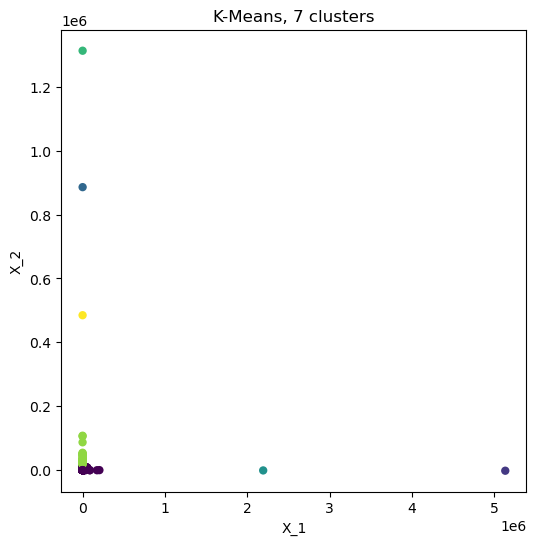

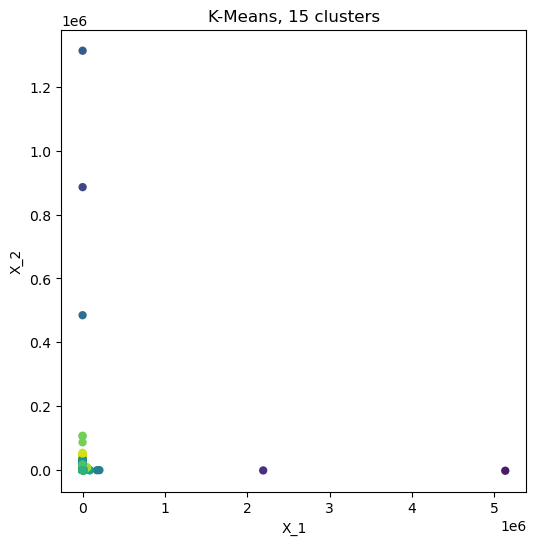

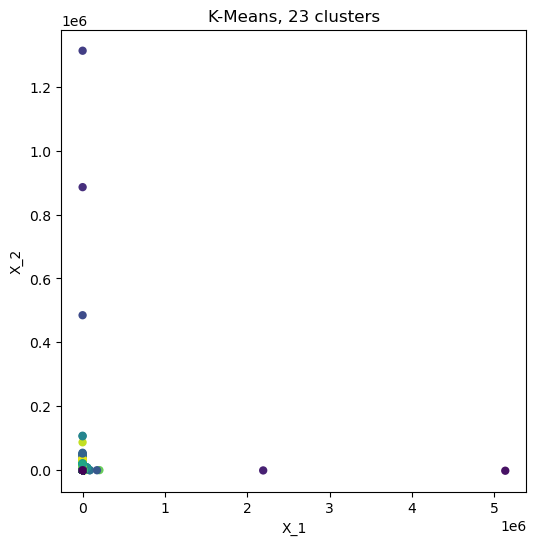

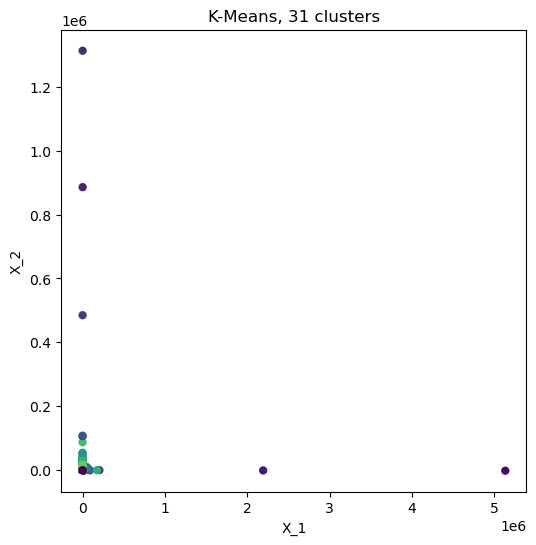

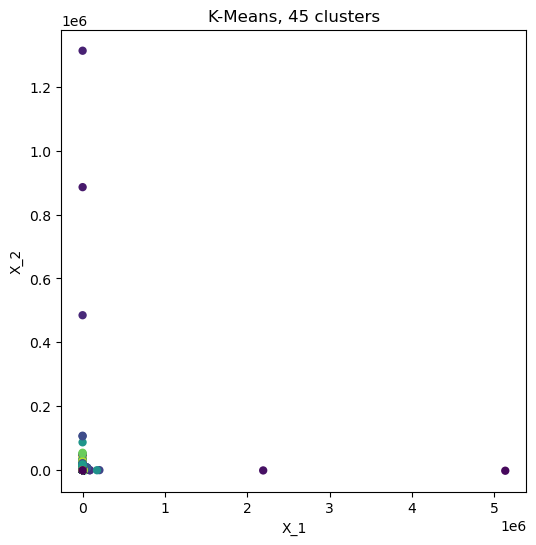

time: 1.39 s (started: 2023-09-12 00:31:38 +03:00)


In [85]:
for k in [7, 15, 23, 31, 45]:
    display_plot(x_train2, km_results[k]['labels'], '2d', title=f"K-Means, {k} clusters")

### Spectral Clustering

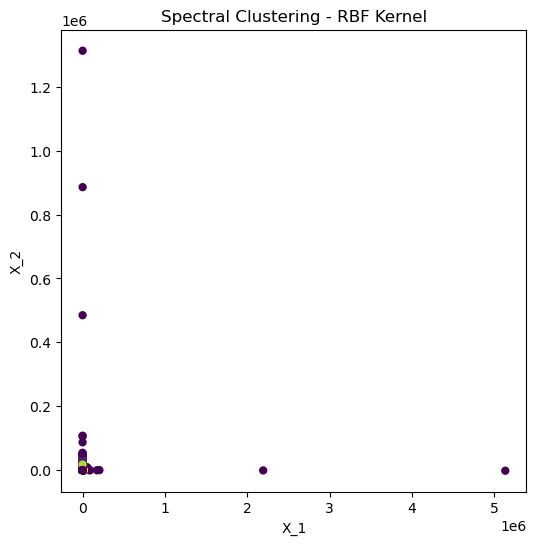

time: 312 ms (started: 2023-09-12 00:31:39 +03:00)


In [86]:
display_plot(x_train2, nc_labels, '2d', title="Spectral Clustering - RBF Kernel")

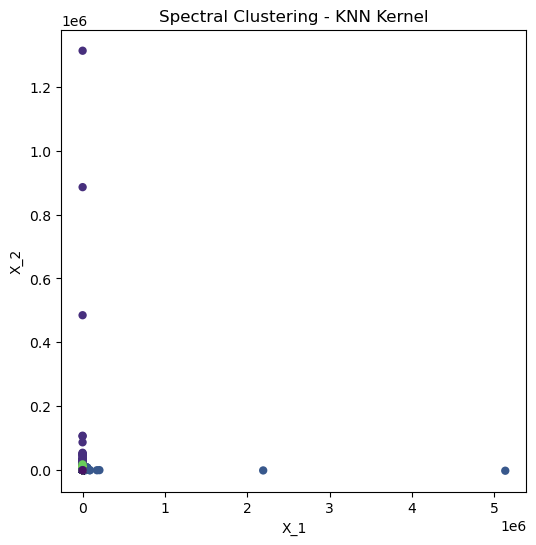

time: 281 ms (started: 2023-09-12 00:31:40 +03:00)


In [87]:
display_plot(x_train2, nc_labels_knn, '2d', title="Spectral Clustering - KNN Kernel")

### DBSCAN

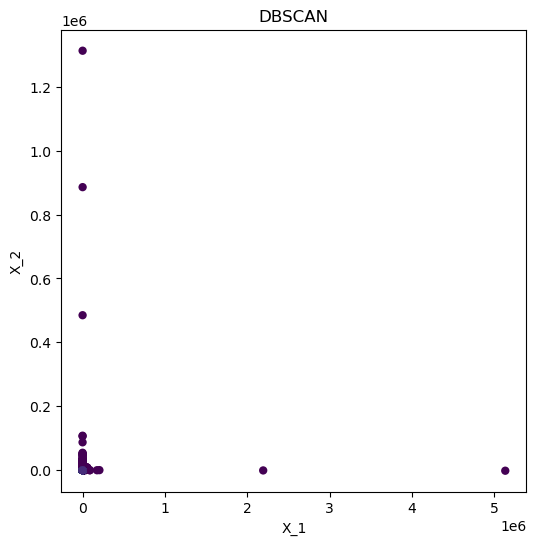

time: 282 ms (started: 2023-09-12 00:31:42 +03:00)


In [88]:
display_plot(x_train2, dbscan_labels, '2d', title=f"DBSCAN")